In [139]:
import os
import csv
import sys
sys.path.insert(0, 'C:\\Users\\Utente\\Desktop\\Dev\\Progetti\\OrderAi\\lib\\')
sys.path.insert(1, 'C:\\Users\\Utente\\Desktop\\Dev\\Progetti\\OrderAi\\Models\\components\\')
import copy
import logging
import numpy as np
#from stats import *
import pandas as pd
import seaborn as sns
from scipy import stats
#from Layer import Layer
import tensorflow as tf 
from preprocessing import *
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.model_selection import train_test_split, KFold
from sklearn.datasets import fetch_california_housing, make_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [140]:
class Layer(tf.Module):
    def __init__(self, activation=tf.identity):
        self.activation = activation
        self.build = False
        self.normalized = False
        
    @tf.function(reduce_retracing=True)
    def xavier_init(self, shape):
        in_dim, out_dim = shape
        xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))
        weight_vals = tf.cast(tf.random.uniform(shape=(in_dim, out_dim), 
                                        minval=-xavier_lim, maxval=xavier_lim, seed=22, dtype=tf.float32), dtype=tf.double)
        return weight_vals

    @tf.function
    def __call__(self, X):
        if not self.build:
            n_samples, n_features = X.shape
            #self.weights = tf.Variable(tf.concat([self.xavier_init(shape=(n_features, n_samples)), tf.ones(shape=(n_features, 1))], axis=1), name="Weights", dtype=tf.double, trainable=True, )
            self.weights = tf.Variable(self.xavier_init(shape=(n_features, n_samples)), name="Weights", dtype=tf.double, trainable=True, )

            self.bias = tf.Variable(tf.ones(shape=1, dtype=tf.double), name="Bias", dtype=tf.double, trainable=True )
            self.build = True

        z = tf.add(tf.matmul(X, self.weights), self.bias)

        #print(X.shape,"*",self.weights.shape,"+",self.bias.shape, "=", z.shape)
        return tf.nn.dropout(self.activation(z), 0.5)

    

In [141]:


def write_stats(samples, features, loss, epochs, lr, batch_size, cross_k, r2, mse_train, mse_test, mae_train, mae_test, residual_train, residual_test):
    with open('../data/stats.csv', 'a') as f:
        newrow = [samples, features, loss, epochs, lr, batch_size, cross_k, r2, mse_train, mse_test, mae_train, mae_test, residual_train, residual_test]
        writer = csv.writer(f)
        writer.writerow(newrow)

def fill_dataset(dataframe: DataFrame):
    for column in dataframe:
        dataframe[column] = dataframe[column].fillna(dataframe[column].mean())
    return dataframe

def normalize_dataset(X):
    return tf.keras.utils.normalize(X)

def remove_outliers(X, threshold=3):
    z = np.abs(stats.zscore(X))
    return X[(z<threshold).all(axis=1)][:, 0:-1], X[(z<threshold).all(axis=1)][: ,-1]

def make_dataset(X_data,y_data,k):
    X_data, y_data = remove_outliers(np.concatenate([X_data, y_data], axis=1))
    def gen():
        for train_index, test_index in KFold(k).split(X_data):
            X_train, X_test = X_data[train_index], X_data[test_index]
            XN_train, XN_test = normalize_dataset(X_data[train_index]), normalize_dataset(X_data[test_index])
            y_train, y_test = y_data[train_index], y_data[test_index]
            yield X_train,XN_train,y_train,X_test,XN_test,y_test

    return tf.data.Dataset.from_generator(gen, (tf.double,tf.double,tf.double,tf.double,tf.double,tf.double))


In [142]:
california = fetch_california_housing()
stock = pd.read_csv('../data/datasets/yahoo_stock.csv')
air = pd.read_csv('../data/datasets/AirQualityUCI.csv')
housing_train = pd.read_csv("../data/datasets/boston_train.csv")
housing_test = pd.read_csv("../data/datasets/boston_test.csv")
housing = pd.concat([housing_train, housing_test])
total_columns=["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
k = 2
epochs = 600
lr = 0.01
batch_size = 200

#X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(housing.data, housing.target, test_size=0.98, random_state=2)
XR, yR = make_regression(n_samples=2000, n_features=8, n_informative=5, noise=50, random_state=4)
X_train2, X_test2, y_train2, y_test2 = train_test_split(XR, yR, test_size=0.20, random_state=2)
columns = ["{0}".format(total_columns[i]) for i in range(XR.shape[1]+1)]
dataframe = pd.DataFrame(np.concatenate([XR, np.reshape(yR, [-1, 1])], axis=1), columns=columns)
#dataframe = pd.DataFrame(housing)

dataframe.head()

,A,B,C,D,E,F,G,H,I
0,0.471507,0.611490,1.375106,-0.182116,0.541070,-1.332438,1.198742,-0.504073,204.095411
1,-2.496178,0.139191,0.092357,0.749328,-0.869763,-0.630400,-0.408196,0.112939,-330.032608
2,-1.020382,0.165316,1.127188,-0.195860,1.475472,-0.697577,-0.084086,-0.117863,170.806125
3,1.192191,0.239251,0.009603,1.530720,0.901205,-0.057431,1.644330,0.751448,218.857632
4,0.677847,-1.480873,1.253116,1.065624,-1.574374,0.107530,0.822625,-0.816147,-100.188169


In [143]:
Y = dataframe['I']
#S = dataframe['Date']
X = dataframe.drop(['I'], axis=1)

data = make_dataset(X, Y.values.reshape(Y.shape[0], 1), k)
vif_data = pd.DataFrame()
vif_data["features"] = dataframe.columns
vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(len(dataframe.columns))]
print(vif_data)

  features        VIF
0        A   4.384870
1        B   2.128959
2        C   3.380372
3        D   1.002593
4        E   3.752702
5        F   1.005637
6        G   1.009884
7        H   1.048807
8        I  10.309548


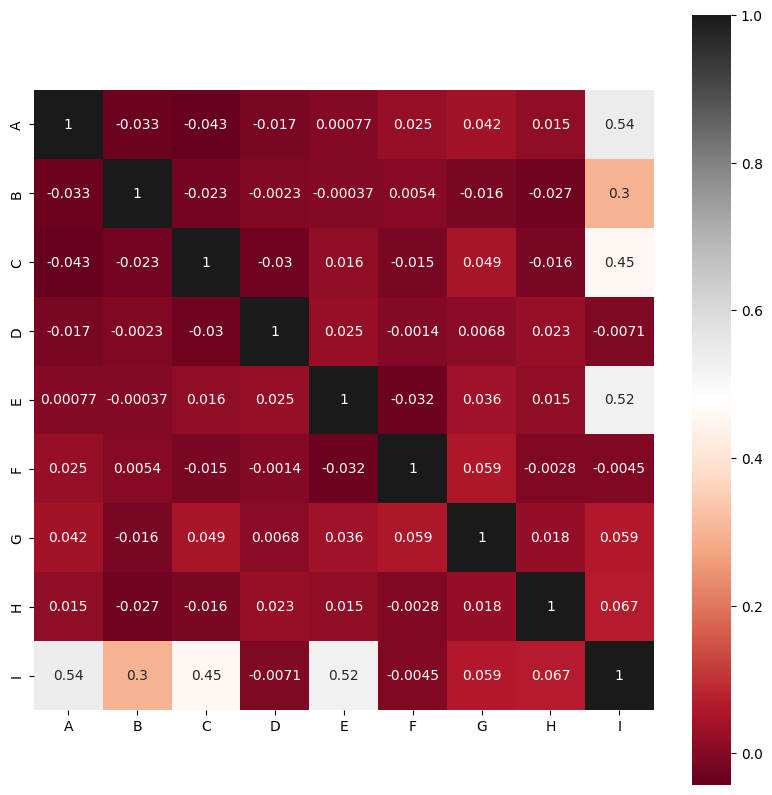

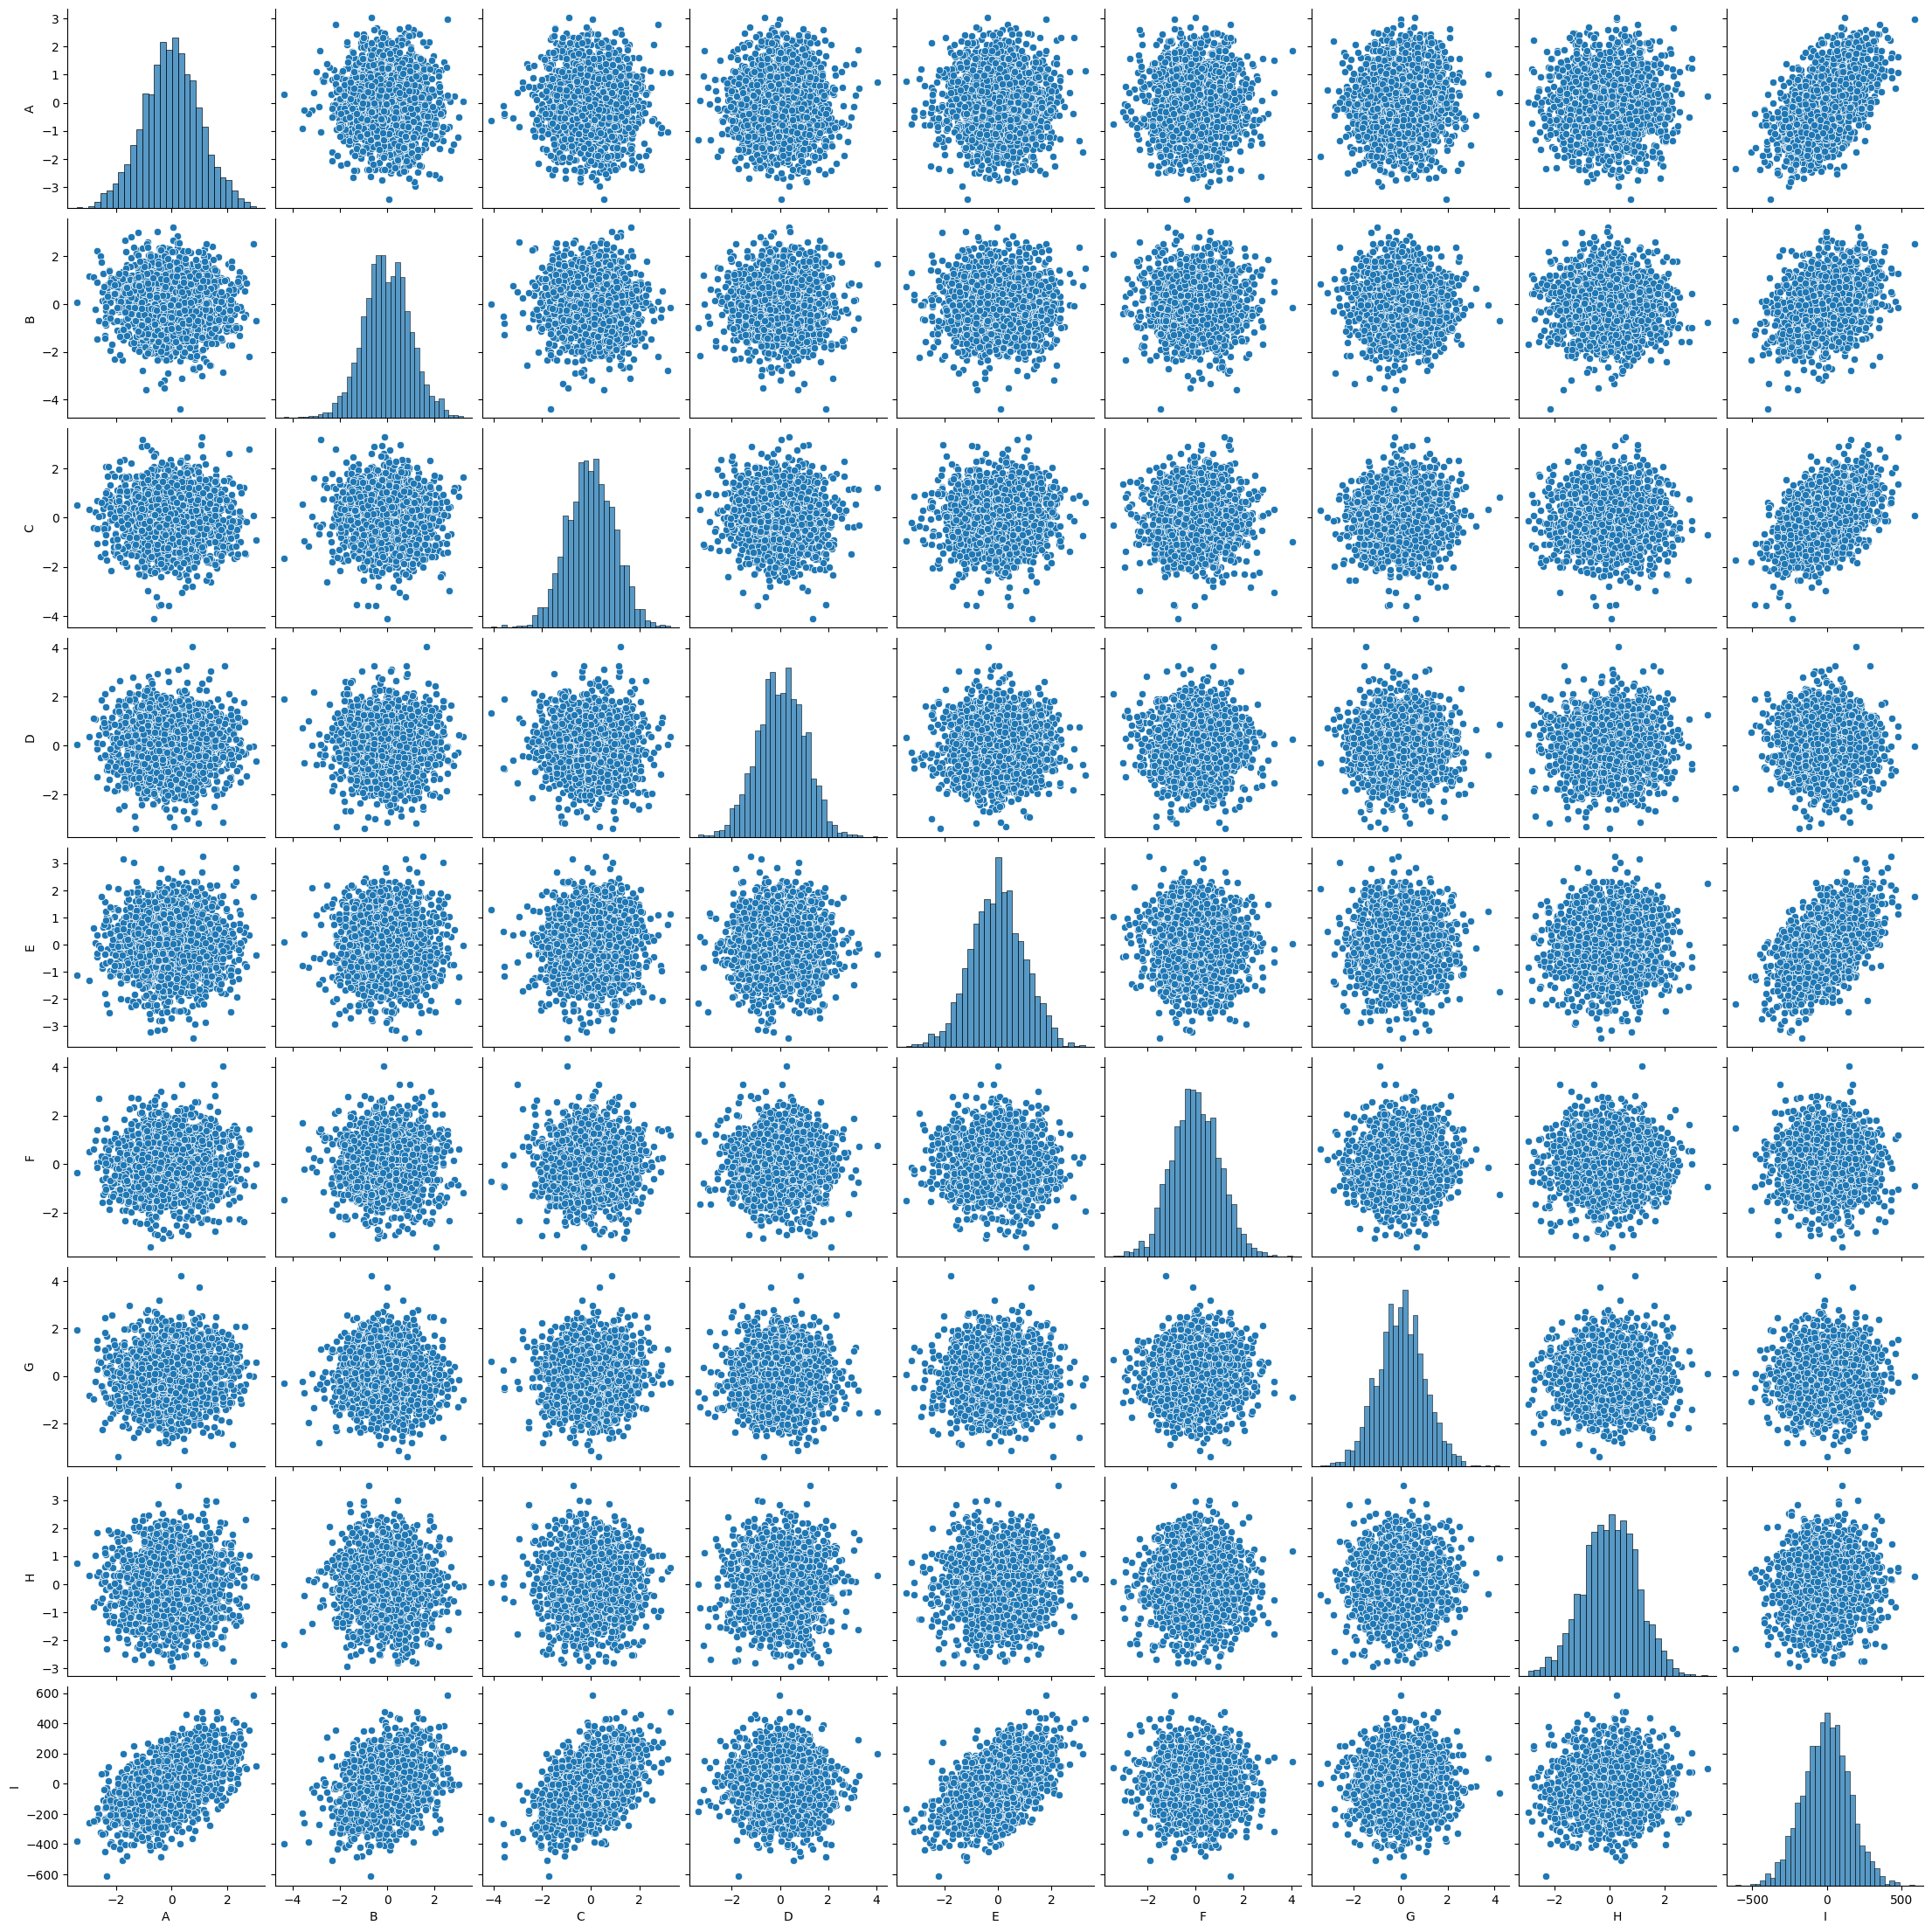

In [144]:
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(dataframe.corr(), cmap = 'RdGy', annot=True, square=True)
sns.pairplot(dataframe)

In [145]:
class MLPLinearRegressor(tf.Module):
    def __init__(self, layers, k, epochs=100, lr=0.01, batch_size=50):
        self.layers = layers
        self.k = k
        self.epochs = epochs
        self.batch_size = batch_size
        self.batch_counter = 0
        self.history_builded = False
        self.learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=epochs, decay_rate=0.50, staircase=True)
        self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
        self.train_mse = tf.keras.metrics.MeanSquaredError()
        self.train_mae = tf.keras.metrics.MeanAbsoluteError()
        self.train_accuracy = tf.keras.metrics.MeanSquaredLogarithmicError()
        self.test_mse = tf.keras.metrics.MeanSquaredError()
        self.test_mae = tf.keras.metrics.MeanAbsoluteError()
        self.test_accuracy = tf.keras.metrics.MeanSquaredLogarithmicError()
        self.regularizer = tf.keras.layers.ActivityRegularization()
        self.loss_history = [e for e in range(epochs*k+1)]
        self.bias_history = [e for e in range(epochs*k+1)]
        self.mae_train_error_history = [e for e in range(epochs*k+1)]
        self.mse_train_error_history = [e for e in range(epochs*k+1)]
        self.mae_test_error_history = [e for e in range(epochs*k+1)]
        self.mse_test_error_history = [e for e in range(epochs*k+1)]
        self.residual_tr = [e for e in range(epochs*k+1)]
        self.residual_tt = [e for e in range(epochs*k+1)]
        self.r2_accuracy_tr = [e for e in range(epochs*k+1)]
        self.r2_accuracy_tt = [e for e in range(epochs*k+1)]

    def reset_history_metrics(self):
        self.train_mse.reset_state()
        self.train_mae.reset_state()
        self.test_mse.reset_state()
        self.test_mae.reset_state()
    
    def update_states(self, loss, i, y, y_test):
        self.bias_history[i] = self.bias
        self.loss_history[i] = loss.numpy()
        self.mae_train_error_history[i] = self.train_mae.result().numpy()
        self.mse_train_error_history[i] = self.train_mse.result().numpy()
        self.mae_test_error_history[i] = self.test_mae.result().numpy()
        self.mse_test_error_history[i] = self.test_mse.result().numpy()
        self.r2_accuracy_tr[i] = self.r2(y, self.predicted_train)
        self.r2_accuracy_tt[i] = self.r2(y_test, self.predicted_test)
        self.residual_tr[i] = tf.reduce_mean(tf.subtract(y, self.predicted_train))
        self.residual_tt[i] = tf.reduce_mean(tf.subtract(y_test, self.predicted_test))

    def calc_metrics(self, y, y_test, e, k, loss):
        self.reset_history_metrics()
        self.train_mae.update_state(y, self.predicted_train)
        self.train_mse.update_state(y, self.predicted_train)
        self.test_mae.update_state(y_test, self.predicted_test)
        self.test_mse.update_state(y_test, self.predicted_test)
        self.update_states(loss, e+(k*self.epochs), y, y_test)

    def calc_history(self, e_, epochs, k):
        if not self.history_builded:
            self.train_history = [[i for i in range(self.predicted_train.shape[0])] for e in range(epochs*self.k+1)]
            self.test_history = [[i for i in range(self.predicted_test.shape[0])] for e in range(epochs*self.k+1)]
            self.history_builded = True
        self.train_history[e_] = self.predicted_train
        self.test_history[e_] = self.predicted_test
        

    def verify_batch(self, X, X_test):
        if self.batch_counter >= X:
            self.batch_counter = 0
        
    def r2(self, y, y_pred):
        return tf.subtract(
            tf.convert_to_tensor(1, dtype=tf.float64), 
            tf.divide(
                tf.reduce_sum(tf.square(tf.subtract(y, y_pred))),
                tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y_pred))))
            )
        )

    @tf.function
    def lasso(self):
        return tf.reduce_sum(tf.norm(self.layers[-1].weights))

    @tf.function
    def ridge(self):
        return tf.reduce_sum(tf.square(tf.norm(self.layers[-1].weights)))

    @tf.function(reduce_retracing=True)
    def loss(self, y, predicted):
        return tf.add(tf.add(tf.losses.MSE(y, predicted), self.lasso()), self.ridge())
        
    """@tf.function(reduce_retracing=True)
    def elastic_loss(self, y, predicted):
        return 1/2(tf.matmul(tf.transpose(tf.subtract(predicted, y)), tf.subtract(predicted, y)))+1/2"""
    
    @tf.function
    def _predict(self, X, bias, compressed_weights, error):
        return tf.reduce_mean(tf.add(tf.add(tf.multiply(X, compressed_weights), bias), error), axis=1, name="Predict")
    
    def predict(self, x):
        return tf.reduce_mean(tf.add(tf.multiply(x, self.compressed_weights), self.bias))

    @tf.function(reduce_retracing=True)
    def _forward(self, X):
        for layer in self.layers:
            X = layer(X)
        return X

    @tf.function(reduce_retracing=True)
    def _backprop(self, X, XN, X_test, y, y_test):
        error_tr = 0
        error_tt = 0
        batch_xn = XN[self.batch_counter:self.batch_counter+self.batch_size, :]
        weights = self._forward(batch_xn)
        bias = self.layers[-1].bias

        compressed_weights = tf.reduce_sum(tf.nn.relu(tf.add(tf.multiply(tf.transpose(batch_xn), tf.reduce_mean(weights, axis=1)), bias)), axis=1)
        predicted_train = self._predict(X, bias, compressed_weights, error_tr)
        predicted_test = self._predict(X_test, bias, compressed_weights, error_tt)
        error_tr = tf.reduce_mean(tf.subtract(y, predicted_train))
        error_tt = tf.reduce_mean(tf.subtract(y_test, predicted_test))
        loss = tf.nn.scale_regularization_loss(self.loss(y, predicted_train))

        #intercept_tr = tf.add(tf.multiply(X, compressed_weights), bias)[:, 0]
        #intercept_tt = tf.add(tf.multiply(X_test, compressed_weights), bias)[:, 0]

        self.vars = [self.layers[0].weights, self.layers[1].weights, self.layers[0].bias, self.layers[1].bias]
        self.batch_counter = self.batch_counter + self.batch_size
        return loss, bias, compressed_weights, predicted_train, predicted_test, error_tt #intercept_tr, intercept_tt

    def fit(self, X, X_test, XN, XN_test, y, y_test, k):
        for e in range(self.epochs+1):
            self.verify_batch(X.shape[0], X_test.shape[0])
            
            with tf.GradientTape(watch_accessed_variables=True, persistent=True) as tape:
                loss, self.bias, self.compressed_weights, self.predicted_train, self.predicted_test, self.error_tt = self._backprop(X, XN, X_test, y, y_test)
            
            grads = tape.gradient(loss, self.vars)  
            self.optimizer.apply_gradients(zip(grads, self.vars))   
            self.calc_metrics(y, y_test, e, k, loss)
            self.calc_history(e, epochs, k)
            if e%50==0:
                print("[{0}] Train Score: {1}, Test Score: {2} Loss: {3} Error: {4} Bias: {5} Weights: {6} ".format(e, np.round(self.r2_accuracy_tr[e], 3), np.round(self.r2_accuracy_tt[e], 3), np.round(loss.numpy(), 3), np.round(model.error_tt.numpy(), 3), np.round(self.bias.numpy(), 3), np.round(self.compressed_weights.numpy(), 3)))
            

kk = k
model = MLPLinearRegressor([
    Layer(activation=tf.sigmoid),
    Layer(activation=tf.identity)
], kk, epochs=epochs, lr=lr, batch_size=batch_size)


def run_model(data, model):
    k = 0
    for data in data.as_numpy_iterator():
        X_train, XN_train, y_train, X_test, XN_test, y_test = data
        model.run(X_train, X_test, XN_train, XN_test, tf.squeeze(y_train), tf.squeeze(y_test), k)
        k = k+1 
        if k==kk:
            write_stats(
                X_train.shape[0]+X_test.shape[0], 
                X_train.shape[1], 
                model.loss_history[-1], 
                epochs, 
                lr, 
                batch_size, 
                kk, 
                model.r2_accuracy_tt[-1].numpy(), 
                model.train_mse.result().numpy(), 
                model.test_mse.result().numpy(), 
                model.train_mae.result().numpy(), 
                model.test_mae.result().numpy(), 
                model.residual_tr[-1].numpy(), 
                model.residual_tt[-1].numpy()
            )
        else:
            write_stats(
                X_train.shape[0]+X_test.shape[0], 
                X_train.shape[1], 
                model.loss_history[-1], 
                epochs, 
                lr, 
                batch_size, 
                kk, 
                model.r2_accuracy_tt[-1], 
                model.train_mse.result().numpy(), 
                model.test_mse.result().numpy(), 
                model.train_mae.result().numpy(), 
                model.test_mae.result().numpy(), 
                model.residual_tr[-1], 
                model.residual_tt[-1]
            )
    return X_train, X_test, XN_train, XN_test, tf.squeeze(y_train), tf.squeeze(y_test)
     
     
X_train, X_test, XN_train, XN_test, y_train, y_test = run_model(data, model)

[0] Train Score: 0.392, Test Score: 0.391 Loss: 14552.879 Error: -5.974 Bias: [1.] Weights: [189.52  191.594 209.881 204.451 198.932 196.362 196.303 204.401] 
[50] Train Score: 0.484, Test Score: 0.5 Loss: 12351.623 Error: -6.324 Bias: [1.216] Weights: [357.24  335.788 275.351 266.863 307.769 298.957 295.563 263.134] 
[100] Train Score: 0.642, Test Score: 0.658 Loss: 9353.608 Error: -5.9 Bias: [1.391] Weights: [433.808 372.22  429.677 236.874 402.536 229.976 267.166 265.956] 
[150] Train Score: 0.699, Test Score: 0.713 Loss: 8209.667 Error: -5.43 Bias: [1.169] Weights: [500.821 389.947 488.163 223.764 435.739 211.689 255.053 259.355] 
[200] Train Score: 0.719, Test Score: 0.732 Loss: 7773.839 Error: -5.096 Bias: [0.896] Weights: [512.971 370.413 489.699 215.547 442.766 194.287 240.863 243.895] 
[250] Train Score: 0.735, Test Score: 0.747 Loss: 7422.359 Error: -4.759 Bias: [0.66] Weights: [524.666 382.606 494.227 209.149 439.359 177.636 222.624 241.151] 
[300] Train Score: 0.747, Test S


Original:  68.25109225085794 
Predicted:  164.152687764476 
Tested: 164.152687764476 

Train_MeanSquaredError:  4356.1284
Train_MeanAbsoluteError:  52.9757
Train_R2Accuracy:  0.8155344084926863
--------------------------------------------------------
Test_MeanSquaredError:  4686.764
Test_MeanAbsoluteError:  53.616287
Test_R2Accuracy:  0.8008942055527134


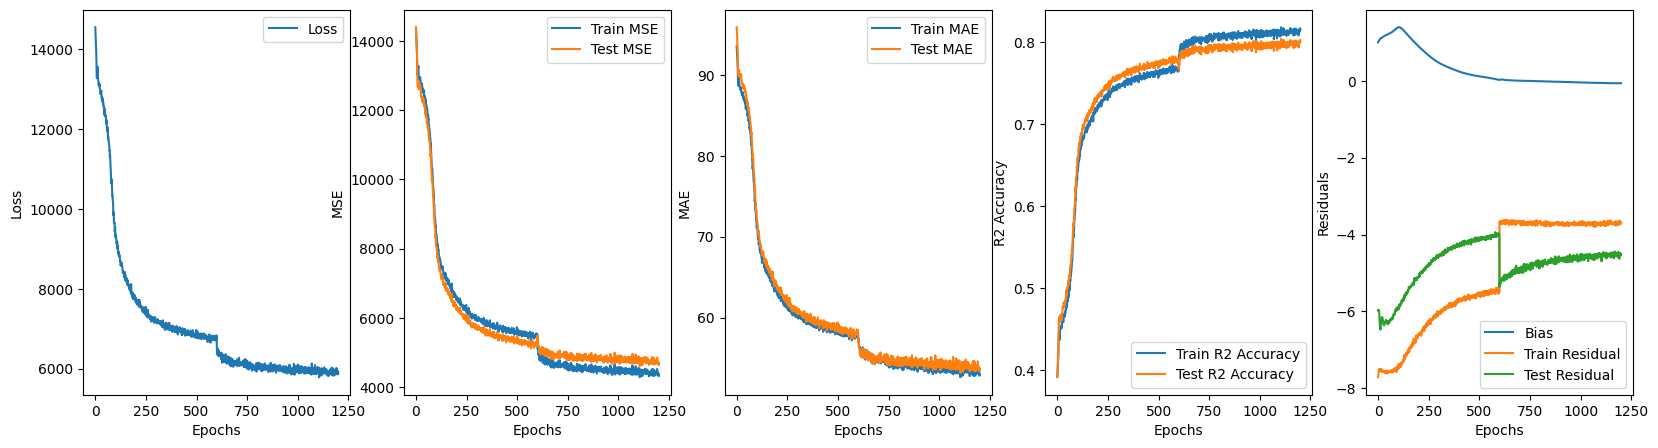

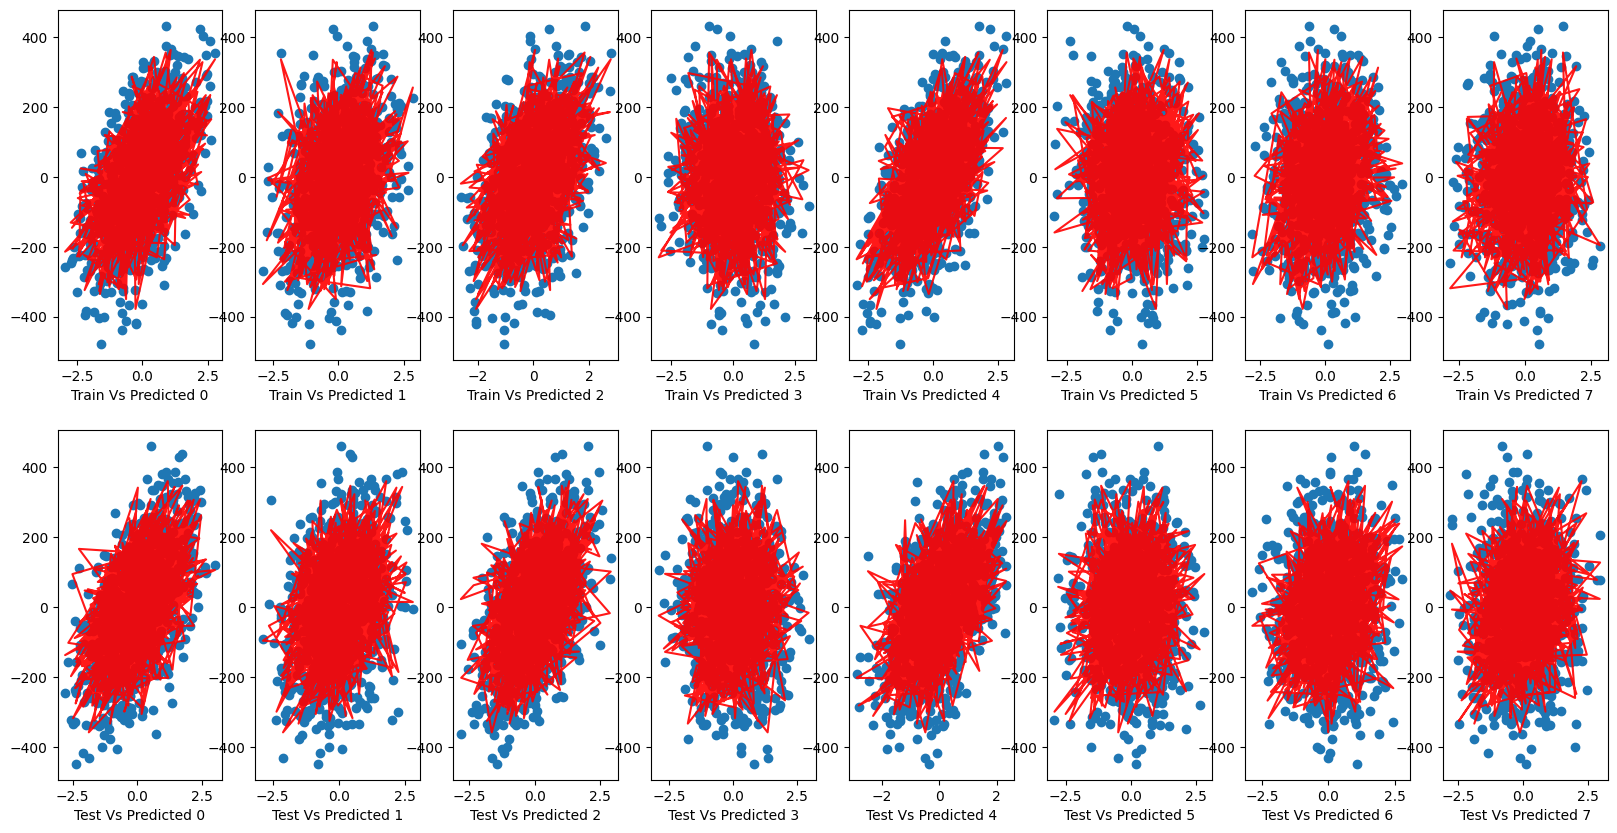

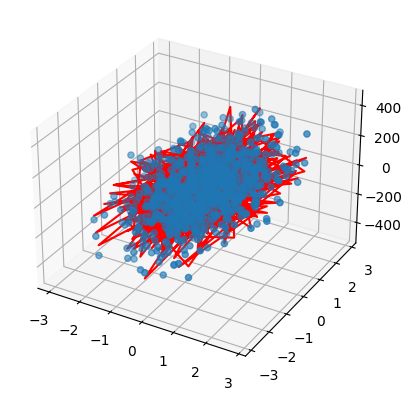

In [146]:
print("\nOriginal: ", y_test[0].numpy(), "\nPredicted: ", model.predict(X_test[0]).numpy(), "\nTested:", model.predicted_test[0].numpy(), "\n")
print("Train_MeanSquaredError: ", model.train_mse.result().numpy())
print("Train_MeanAbsoluteError: ", model.train_mae.result().numpy())
print("Train_R2Accuracy: ", model.r2_accuracy_tr[-1].numpy()) 
print('--------------------------------------------------------')
print("Test_MeanSquaredError: ", model.test_mse.result().numpy())
print("Test_MeanAbsoluteError: ", model.test_mae.result().numpy())
print("Test_R2Accuracy: ", model.r2_accuracy_tt[-1].numpy()) 
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
ax[0].plot([e for e in range(epochs*kk+1)], model.loss_history, label="Loss")
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot([e for e in range(epochs*kk+1)], model.mse_train_error_history, label="Train MSE")
ax[1].plot([e for e in range(epochs*kk+1)], model.mse_test_error_history, label="Test MSE")
ax[1].set_ylabel('MSE')
ax[1].set_xlabel('Epochs')
ax[1].legend()

ax[4].plot([e for e in range(epochs*kk+1)], model.bias_history, label="Bias")
ax[4].plot([e for e in range(epochs*kk+1)], model.residual_tr, label="Train Residual")
ax[4].plot([e for e in range(epochs*kk+1)], model.residual_tt, label="Test Residual")
ax[4].set_ylabel('Residuals')
ax[4].set_xlabel('Epochs')
ax[4].legend()

ax[3].plot([e for e in range(epochs*kk+1)], model.r2_accuracy_tr, label="Train R2 Accuracy")
ax[3].plot([e for e in range(epochs*kk+1)], model.r2_accuracy_tt, label="Test R2 Accuracy")
ax[3].set_ylabel('R2 Accuracy')
ax[3].set_xlabel('Epochs')
ax[3].legend()

ax[2].plot([e for e in range(epochs*kk+1)], model.mae_train_error_history, label="Train MAE")
ax[2].plot([e for e in range(epochs*kk+1)], model.mae_test_error_history, label="Test MAE")
ax[2].set_ylabel('MAE')
ax[2].set_xlabel('Epochs')
ax[2].legend()

fig2, ax2 = plt.subplots(2, X_train.shape[1], figsize=(20, 10))
for i in range(X_train.shape[1]):
    if X_train.shape[1] == 1:
        ax2[0].scatter(X_train[:], y_train[:], cmap='viridis')
        ax2[0].plot(X_train[:], model.predicted_train[:], color='r', zorder = 10, alpha = 0.9)
        #ax2[0].set_ylim([-300, 300])
        #ax2[0].set_xlim(-3,3)
        ax2[0].set_xlabel("Train Vs Predicted {0}".format(i))

        ax2[1].scatter(X_test[:], y_test[:], cmap='viridis')
        ax2[1].plot(X_test[:], model.predicted_test[:], color='r', zorder = 10, alpha = 0.9)
        #ax2[1].set_ylim([-200, 200])
        #ax2[1].set_xlim(-3,3)
        ax2[1].set_xlabel("Test Vs Predicted {0}".format(i))

    else:
        ax2[0, i].scatter(X_train[:, i], y_train[:], cmap='viridis')
        ax2[0, i].plot(X_train[:, i], model.predicted_train[:], color='r', zorder = 10, alpha = 0.9)
        #ax2[0, i].set_ylim([-300, 300])
        #ax2[0, i].set_xlim(-3,3)
        ax2[0, i].set_xlabel("Train Vs Predicted {0}".format(i))

        ax2[1, i].scatter(X_test[:, i], y_test[:], cmap='viridis')
        ax2[1, i].plot(X_test[:, i], model.predicted_test[:], color='r', zorder = 10, alpha = 0.9)
        #ax2[1, i].set_ylim([-200, 200])
        #ax2[1, i].set_xlim(-3,3)
        ax2[1, i].set_xlabel("Test Vs Predicted {0}".format(i))

fig3d = plt.figure()
ax3d = fig3d.add_subplot(projection='3d')
ax3d.scatter(X_train[:, 0], X_train[:, 1], y_train[:])
ax3d.plot(X_train[:, 0], X_train[:, 1], model.predicted_train[:], color='r')
plt.show()
